## LAION-Aesthetics V2 Predictor

- https://github.com/christophschuhmann/improved-aesthetic-predictor/
- https://laion.ai/blog/laion-aesthetics/

In [1]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2g4bvefz
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2g4bvefz


In [2]:
from pathlib import Path

state_name = "sac+logos+ava1-l14-linearMSE.pth"
if not Path(state_name).exists():
    url = f"https://github.com/christophschuhmann/improved-aesthetic-predictor/blob/main/{state_name}?raw=true"
    import requests
    r = requests.get(url)
    with open(state_name, "wb") as f:
        f.write(r.content)



In [3]:
# base from: https://github.com/christophschuhmann/improved-aesthetic-predictor/blob/main/simple_inference.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# load the model you trained previously or the model available in this repo
pt_state = torch.load(state_name)

# CLIP embedding dim is 768 for CLIP ViT L 14
predictor = AestheticPredictor(768)
predictor.load_state_dict(pt_state)
predictor.to(device)
predictor.eval()

AestheticPredictor(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [5]:
import clip
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)



In [6]:
import numpy as np
from PIL import Image

def get_image_features(image, device=device, model=clip_model, preprocess=clip_preprocess):
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        # l2 normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.cpu().detach().numpy()
    return image_features

def get_score(image):
    image_features = get_image_features(image)
    score = predictor(torch.from_numpy(image_features).to(device).float())
    return score.item()




In [7]:
!wget https://thumbs.dreamstime.com/b/lovely-cat-as-domestic-animal-view-pictures-182393057.jpg -O cat.jpg


--2022-09-20 07:11:37--  https://thumbs.dreamstime.com/b/lovely-cat-as-domestic-animal-view-pictures-182393057.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105055 (103K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 102.59K  --.-KB/s    in 0.02s   

2022-09-20 07:11:37 (4.85 MB/s) - ‘cat.jpg’ saved [105055/105055]



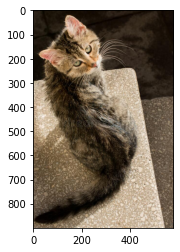

In [8]:
import matplotlib.pyplot as plt
pil_image = Image.open("cat.jpg")
plt.imshow(pil_image)


In [9]:
get_score(pil_image)

4.603564262390137